# Minutes Projection Validation Analysis

This notebook validates whether **minutes projections are the bottleneck** in our fantasy point predictions.

## Questions to Answer:
1. How accurate are SportsLine's minutes projections?
2. Is our model good at predicting fantasy points **per minute**?
3. How much would perfect minutes improve our overall accuracy?
4. **Should we build a custom minutes prediction system?**

## Required Data:
- Run this after 3-5 days of games to have enough data
- Requires PROJECTED_MIN and ACTUAL_MIN columns (added Oct 29, 2025)

In [28]:
import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from datetime import datetime, timedelta
import pickle
import logging

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

# Configure logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

print("Imports successful")

Imports successful


## 1. Load Data from S3

In [29]:
# Load predictions data
s3 = boto3.client('s3')
BUCKET_NAME = 'nba-prediction-ibracken'

obj = s3.get_object(Bucket=BUCKET_NAME, Key='data/daily_predictions/current.parquet')
df = pd.read_parquet(BytesIO(obj['Body'].read()))

print(f"Total predictions loaded: {len(df)}")
print(f"Date range: {df['GAME_DATE'].min()} to {df['GAME_DATE'].max()}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Total predictions loaded: 1145
Date range: 2025-10-24 to 2025-11-05

Columns: ['PLAYER', 'GAME_DATE', 'PPG_PROJECTION', 'MY_MODEL_PREDICTED_FP', 'MY_MODEL_CLOSER_PREDICTION', 'SALARY', 'POSITION', 'PROJECTED_MIN', 'ACTUAL_FP', 'ACTUAL_MIN']

First few rows:


,PLAYER,GAME_DATE,PPG_PROJECTION,MY_MODEL_PREDICTED_FP,MY_MODEL_CLOSER_PREDICTION,SALARY,POSITION,PROJECTED_MIN,ACTUAL_FP,ACTUAL_MIN
0,alperen sengun,2025-10-24,44.7,52.272,False,9400.0,None,NaN,41.9,38.0
1,amen thompson,2025-10-24,37.6,32.874,True,7700.0,None,NaN,14.3,30.0
2,andrew wiggins,2025-10-24,34.6,31.209,True,5800.0,None,NaN,26.9,24.0
3,anfernee simons,2025-10-24,27.7,30.178,False,6300.0,None,NaN,24.2,27.0
4,anthony black,2025-10-24,18.3,12.389,True,4000.0,None,NaN,13.6,21.0


In [30]:
# Filter to complete records (has all required data)
df_complete = df.dropna(subset=['PROJECTED_MIN', 'ACTUAL_MIN', 'MY_MODEL_PREDICTED_FP', 'ACTUAL_FP']).copy()

print(f"Complete predictions (with actual results): {len(df_complete)}")
print(f"Completion rate: {len(df_complete)/len(df)*100:.1f}%")
print(f"\nUnique players: {df_complete['PLAYER'].nunique()}")
print(f"Unique dates: {df_complete['GAME_DATE'].nunique()}")

if len(df_complete) < 50:
    print(f"\n⚠️  WARNING: Only {len(df_complete)} complete records. Recommend waiting until 100+ for reliable analysis.")
else:
    print(f"\n✅ Sufficient data for analysis ({len(df_complete)} records)")

Complete predictions (with actual results): 496
Completion rate: 43.3%

Unique players: 268
Unique dates: 5

✅ Sufficient data for analysis (496 records)


## 2. Minutes Projection Accuracy

How good is SportsLine at predicting minutes?

In [31]:
# Calculate minutes errors
df_complete['MIN_ERROR'] = abs(df_complete['PROJECTED_MIN'] - df_complete['ACTUAL_MIN'])
df_complete['MIN_ERROR_PCT'] = (df_complete['MIN_ERROR'] / df_complete['ACTUAL_MIN']) * 100
df_complete['MIN_DIFF'] = df_complete['PROJECTED_MIN'] - df_complete['ACTUAL_MIN']  # signed difference

print("=" * 60)
print("MINUTES PROJECTION ACCURACY")
print("=" * 60)
print(f"\nMean Absolute Error (MAE):     {df_complete['MIN_ERROR'].mean():.2f} minutes")
print(f"Median Absolute Error:          {df_complete['MIN_ERROR'].median():.2f} minutes")
print(f"Standard Deviation:             {df_complete['MIN_ERROR'].std():.2f} minutes")
print(f"\nMean % Error:                   {df_complete['MIN_ERROR_PCT'].mean():.1f}%")
print(f"Median % Error:                 {df_complete['MIN_ERROR_PCT'].median():.1f}%")

print(f"\nBias (avg over/under prediction): {df_complete['MIN_DIFF'].mean():+.2f} minutes")
if df_complete['MIN_DIFF'].mean() > 1:
    print("  → SportsLine tends to OVER-project minutes")
elif df_complete['MIN_DIFF'].mean() < -1:
    print("  → SportsLine tends to UNDER-project minutes")
else:
    print("  → No systematic bias detected")

# Error distribution
print(f"\nError Distribution:")
print(f"  Within ±3 min:  {(df_complete['MIN_ERROR'] <= 3).sum():4d} ({(df_complete['MIN_ERROR'] <= 3).mean()*100:.1f}%)")
print(f"  Within ±5 min:  {(df_complete['MIN_ERROR'] <= 5).sum():4d} ({(df_complete['MIN_ERROR'] <= 5).mean()*100:.1f}%)")
print(f"  Within ±7 min:  {(df_complete['MIN_ERROR'] <= 7).sum():4d} ({(df_complete['MIN_ERROR'] <= 7).mean()*100:.1f}%)")
print(f"  Within ±10 min: {(df_complete['MIN_ERROR'] <= 10).sum():4d} ({(df_complete['MIN_ERROR'] <= 10).mean()*100:.1f}%)")
print(f"  >10 min error:  {(df_complete['MIN_ERROR'] > 10).sum():4d} ({(df_complete['MIN_ERROR'] > 10).mean()*100:.1f}%)")

MINUTES PROJECTION ACCURACY

Mean Absolute Error (MAE):     4.62 minutes
Median Absolute Error:          4.00 minutes
Standard Deviation:             3.90 minutes

Mean % Error:                   31.3%
Median % Error:                 14.3%

Bias (avg over/under prediction): -0.05 minutes
  → No systematic bias detected

Error Distribution:
  Within ±3 min:   245 (49.4%)
  Within ±5 min:   351 (70.8%)
  Within ±7 min:   399 (80.4%)
  Within ±10 min:  446 (89.9%)
  >10 min error:    50 (10.1%)


## 4. Visualizations

In [32]:
# Simulate perfect minutes scenario by re-running the model with actual minutes
print("Loading trained model and box scores to properly test perfect minutes scenario...")

# Load the trained model
model_obj = s3.get_object(Bucket=BUCKET_NAME, Key='models/RFCluster.sav')
rf = pickle.load(BytesIO(model_obj['Body'].read()))

# Load box scores to reconstruct features
box_scores_obj = s3.get_object(Bucket=BUCKET_NAME, Key='data/box_scores/current.parquet')
df_box = pd.read_parquet(BytesIO(box_scores_obj['Body'].read()))

print(f"Loaded {len(df_box)} box score records")

# Get all possible clusters and opponents from the training data
all_clusters = df_box['CLUSTER'].dropna().unique()
all_nba_teams = [
    'ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW',
    'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK',
    'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'
]

# Build expected feature list in training order
# Base features first
base_features = ['Last3_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'Career_FP_Avg', 'Games_Played_Career', 'MIN', 'IS_HOME', 'REST_DAYS']

# Then cluster columns (sorted alphabetically as pd.get_dummies does)
cluster_columns = sorted([f'CLUSTER_{c}' for c in all_clusters if pd.notna(c)])
if 'CLUSTER_CLUSTER_NAN' not in cluster_columns:
    cluster_columns.append('CLUSTER_CLUSTER_NAN')
cluster_columns = sorted(cluster_columns)

# Then opponent columns (sorted alphabetically)
opponent_columns = sorted([f'OPPONENT_{team}' for team in all_nba_teams])

# Combine all features in order
expected_features = base_features + cluster_columns + opponent_columns

print(f"Reconstructed {len(expected_features)} expected features:")
print(f"  Base: {len(base_features)}")
print(f"  Clusters: {len(cluster_columns)}")
print(f"  Opponents: {len(opponent_columns)}")

# We need to reconstruct the features for each prediction
predictions_with_perfect_min = []
failed_reconstructions = 0

for idx, row in df_complete.iterrows():
    player = row['PLAYER']
    game_date = pd.to_datetime(row['GAME_DATE'])
    
    # Find the corresponding box score entry
    box_entry = df_box[(df_box['PLAYER'] == player) & (pd.to_datetime(df_box['GAME_DATE']) == game_date)]
    
    if box_entry.empty:
        # If we can't find the box score entry, skip this prediction
        predictions_with_perfect_min.append(np.nan)
        failed_reconstructions += 1
        continue
    
    box_entry = box_entry.iloc[0]
    
    # Start with all features as 0
    feature_dict = {feat: 0 for feat in expected_features}
    
    # Set base numeric features
    feature_dict['Last3_FP_Avg'] = box_entry.get('Last3_FP_Avg', 0)
    feature_dict['Last7_FP_Avg'] = box_entry.get('Last7_FP_Avg', 0)
    feature_dict['Season_FP_Avg'] = box_entry.get('Season_FP_Avg', 0)
    feature_dict['Career_FP_Avg'] = box_entry.get('Career_FP_Avg', 0)
    feature_dict['Games_Played_Career'] = box_entry.get('Games_Played_Career', 0)
    feature_dict['MIN'] = row['ACTUAL_MIN']  # Use actual minutes instead of projected
    feature_dict['IS_HOME'] = box_entry.get('IS_HOME', 0)
    feature_dict['REST_DAYS'] = box_entry.get('REST_DAYS', 3)
    
    # Set cluster dummy (one-hot encoded)
    cluster_value = box_entry.get('CLUSTER', 'CLUSTER_NAN')
    if pd.notna(cluster_value):
        cluster_col = f'CLUSTER_{cluster_value}'
        if cluster_col in feature_dict:
            feature_dict[cluster_col] = 1
    
    # Set opponent dummy (one-hot encoded)
    opponent_value = box_entry.get('OPPONENT', 'UNKNOWN')
    if pd.notna(opponent_value) and opponent_value != 'UNKNOWN':
        opponent_col = f'OPPONENT_{opponent_value}'
        if opponent_col in feature_dict:
            feature_dict[opponent_col] = 1
    
    # Convert to numpy array in the correct feature order
    feature_array = np.array([feature_dict[feat] for feat in expected_features]).reshape(1, -1)
    
    # Predict with actual minutes
    prediction = rf.predict(feature_array)[0]
    predictions_with_perfect_min.append(prediction)

df_complete['FP_WITH_PERFECT_MIN'] = predictions_with_perfect_min

if failed_reconstructions > 0:
    print(f"⚠️  Could not reconstruct features for {failed_reconstructions} predictions")

# Calculate errors
df_complete['ERROR_CURRENT'] = abs(df_complete['MY_MODEL_PREDICTED_FP'] - df_complete['ACTUAL_FP'])
df_complete['ERROR_PERFECT_MIN'] = abs(df_complete['FP_WITH_PERFECT_MIN'] - df_complete['ACTUAL_FP'])
df_complete['ERROR_IMPROVEMENT'] = df_complete['ERROR_CURRENT'] - df_complete['ERROR_PERFECT_MIN']

# Filter out any rows where we couldn't reconstruct features
df_complete_valid = df_complete[df_complete['FP_WITH_PERFECT_MIN'].notna()].copy()

# Also compare against DFF baseline
df_dff = df_complete_valid.dropna(subset=['PPG_PROJECTION']).copy()
df_dff['ERROR_DFF'] = abs(df_dff['PPG_PROJECTION'] - df_dff['ACTUAL_FP'])

improvement_pct = ((df_complete_valid['ERROR_CURRENT'].mean() - df_complete_valid['ERROR_PERFECT_MIN'].mean()) / df_complete_valid['ERROR_CURRENT'].mean() * 100)

print("=" * 60)
print("IMPACT OF PERFECT MINUTES (RE-RUN MODEL WITH ACTUAL MINUTES)")
print("=" * 60)
print(f"\nValid predictions: {len(df_complete_valid)} / {len(df_complete)}")
print(f"\nCurrent MAE (with SportsLine minutes): {df_complete_valid['ERROR_CURRENT'].mean():.2f} FP")
print(f"Hypothetical MAE (with perfect minutes): {df_complete_valid['ERROR_PERFECT_MIN'].mean():.2f} FP")
print(f"\nPotential Improvement: {improvement_pct:.1f}%")
print(f"Average error reduction: {df_complete_valid['ERROR_IMPROVEMENT'].mean():.2f} FP per prediction")

if len(df_dff) > 0:
    print(f"\n--- Comparison to DailyFantasyFuel ---")
    print(f"DFF Baseline MAE:                      {df_dff['ERROR_DFF'].mean():.2f} FP")
    print(f"Our Model (current):                   {df_dff['ERROR_CURRENT'].mean():.2f} FP")
    print(f"Our Model (with perfect minutes):      {df_dff['ERROR_PERFECT_MIN'].mean():.2f} FP")
    
    if df_dff['ERROR_PERFECT_MIN'].mean() < df_dff['ERROR_DFF'].mean():
        print(f"\n✅ With perfect minutes, we'd beat DFF by {df_dff['ERROR_DFF'].mean() - df_dff['ERROR_PERFECT_MIN'].mean():.2f} FP")
    else:
        print(f"\n⚠️  Even with perfect minutes, DFF is better by {df_dff['ERROR_PERFECT_MIN'].mean() - df_dff['ERROR_DFF'].mean():.2f} FP")

# Show players who would improve most
print(f"\nTop 10 Players Who Would Improve Most with Perfect Minutes:")
top_improvements = df_complete_valid.nlargest(10, 'ERROR_IMPROVEMENT')[['PLAYER', 'PROJECTED_MIN', 'ACTUAL_MIN', 'ERROR_CURRENT', 'ERROR_PERFECT_MIN', 'ERROR_IMPROVEMENT']]
print(top_improvements.to_string(index=False))

# Update df_complete for later cells
df_complete = df_complete_valid

Loading trained model and box scores to properly test perfect minutes scenario...


Loaded 2452 box score records
Reconstructed 54 expected features:
  Base: 8
  Clusters: 16
  Opponents: 30
IMPACT OF PERFECT MINUTES (RE-RUN MODEL WITH ACTUAL MINUTES)

Valid predictions: 496 / 496

Current MAE (with SportsLine minutes): 8.06 FP
Hypothetical MAE (with perfect minutes): 5.87 FP

Potential Improvement: 27.2%
Average error reduction: 2.19 FP per prediction

--- Comparison to DailyFantasyFuel ---
DFF Baseline MAE:                      7.39 FP
Our Model (current):                   8.06 FP
Our Model (with perfect minutes):      5.87 FP

✅ With perfect minutes, we'd beat DFF by 1.52 FP

Top 10 Players Who Would Improve Most with Perfect Minutes:
           PLAYER  PROJECTED_MIN  ACTUAL_MIN  ERROR_CURRENT  ERROR_PERFECT_MIN  ERROR_IMPROVEMENT
        josh hart           30.0        15.0         30.779             11.969             18.810
   kyshawn george           36.0        24.0         19.425              1.389             18.036
       tyus jones           32.0        

## 5. Time Series Analysis (Are errors getting worse over time?)


✅ Time series saved to images/minutes_time_series.png


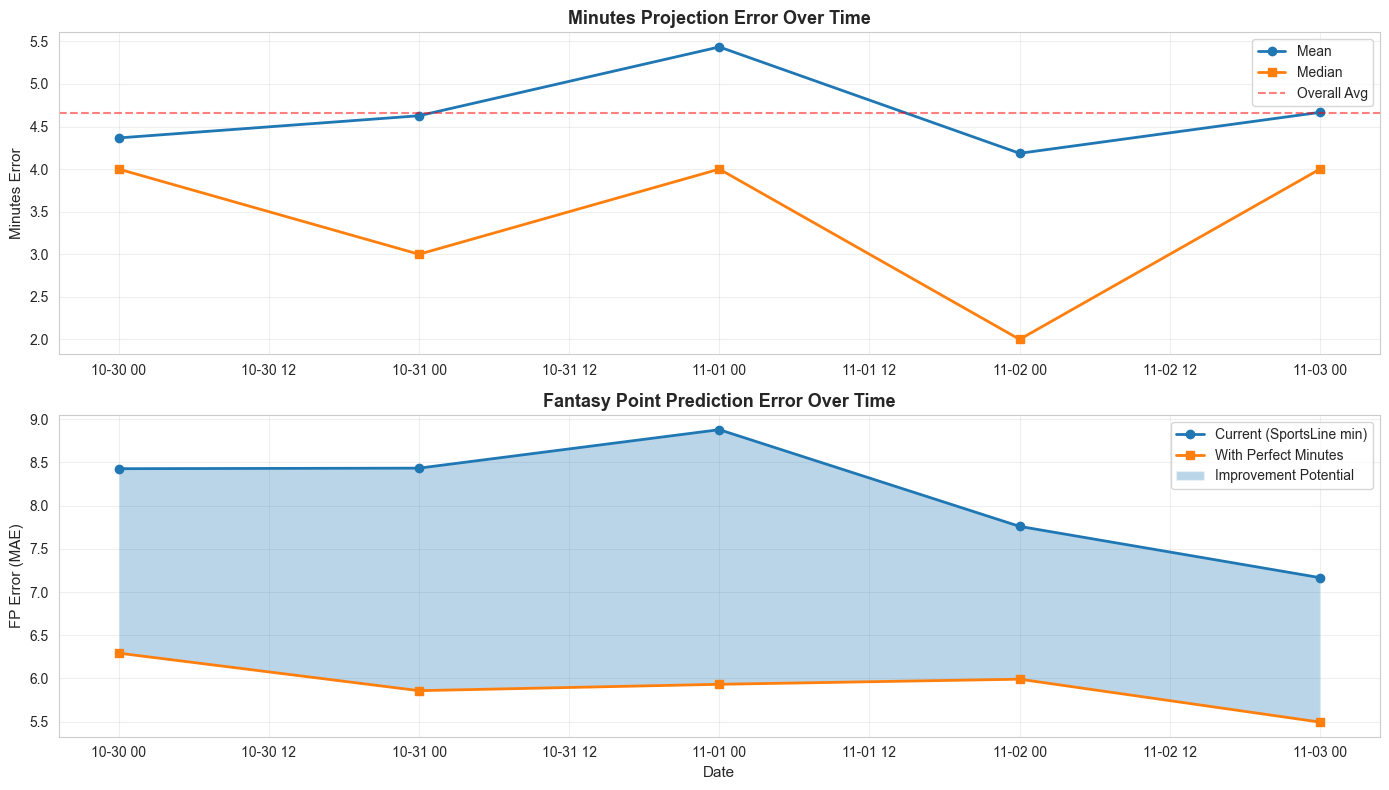


Daily Statistics:
      DATE  MIN_ERROR_MEAN  MIN_ERROR_MEDIAN  FP_ERROR_CURRENT  FP_ERROR_PERFECT  NUM_PLAYERS
2025-10-30        4.366197               4.0          8.427761          6.292676           71
2025-10-31        4.626761               3.0          8.433965          5.858380          142
2025-11-01        5.434783               4.0          8.879362          5.932058           69
2025-11-02        4.185567               2.0          7.759959          5.991165           97
2025-11-03        4.666667               4.0          7.166444          5.494496          117


In [33]:
# Group by date
daily_stats = df_complete.groupby('GAME_DATE').agg({
    'MIN_ERROR': ['mean', 'median'],
    'ERROR_CURRENT': 'mean',
    'ERROR_PERFECT_MIN': 'mean',
    'PLAYER': 'count'
}).reset_index()

daily_stats.columns = ['DATE', 'MIN_ERROR_MEAN', 'MIN_ERROR_MEDIAN', 'FP_ERROR_CURRENT', 'FP_ERROR_PERFECT', 'NUM_PLAYERS']

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Minutes error over time
axes[0].plot(daily_stats['DATE'], daily_stats['MIN_ERROR_MEAN'], marker='o', linewidth=2, label='Mean')
axes[0].plot(daily_stats['DATE'], daily_stats['MIN_ERROR_MEDIAN'], marker='s', linewidth=2, label='Median')
axes[0].axhline(daily_stats['MIN_ERROR_MEAN'].mean(), color='red', linestyle='--', alpha=0.5, label='Overall Avg')
axes[0].set_ylabel('Minutes Error', fontsize=11)
axes[0].set_title('Minutes Projection Error Over Time', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# FP error comparison over time
axes[1].plot(daily_stats['DATE'], daily_stats['FP_ERROR_CURRENT'], marker='o', linewidth=2, label='Current (SportsLine min)')
axes[1].plot(daily_stats['DATE'], daily_stats['FP_ERROR_PERFECT'], marker='s', linewidth=2, label='With Perfect Minutes')
axes[1].fill_between(daily_stats['DATE'], daily_stats['FP_ERROR_CURRENT'], daily_stats['FP_ERROR_PERFECT'], alpha=0.3, label='Improvement Potential')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('FP Error (MAE)', fontsize=11)
axes[1].set_title('Fantasy Point Prediction Error Over Time', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/minutes_time_series.png', dpi=300, bbox_inches='tight')
print("\n✅ Time series saved to images/minutes_time_series.png")
plt.show()

print("\nDaily Statistics:")
print(daily_stats.to_string(index=False))

## 6. FINAL RECOMMENDATION

Decision matrix based on data analysis

In [36]:
print("=" * 70)
print("FINAL RECOMMENDATION: SHOULD WE BUILD A MINUTES PREDICTION SYSTEM?")
print("=" * 70)

mae_threshold = 4.0  # minutes
improvement_threshold = 15.0  # percent

minutes_mae = df_complete['MIN_ERROR'].mean()

print(f"\nKey Metrics:")
print(f"  Minutes MAE:           {minutes_mae:.2f} min (threshold: {mae_threshold})")
print(f"  Improvement Potential: {improvement_pct:.1f}% (threshold: {improvement_threshold}%)")

print(f"\nDecision Tree:")

if minutes_mae > mae_threshold and improvement_pct > improvement_threshold:
    print("\n" + "="*70)
    print("✅ STRONG YES: BUILD MINUTES PREDICTION SYSTEM")
    print("="*70)
    print(f"\nReasons:")
    print(f"  • Minutes projections are inaccurate (MAE = {minutes_mae:.1f} min)")
    print(f"  • High improvement potential ({improvement_pct:.1f}%)")
    print(f"  • This is clearly the bottleneck in your predictions")
    print(f"\nNext Steps:")
    print(f"  1. Build minutes prediction model (Random Forest)")
    print(f"  2. Features: season avg, last 5 games, injuries, starter status, rest days")
    print(f"  3. Scrape injury reports and game spreads")
    print(f"  4. Target: Reduce MAE from {minutes_mae:.1f} to <5 minutes")
    print(f"  5. Expected FP MAE improvement: {df_complete['ERROR_CURRENT'].mean():.1f} → {df_complete['ERROR_PERFECT_MIN'].mean():.1f}")
    
elif minutes_mae > mae_threshold and improvement_pct <= improvement_threshold:
    print("\n" + "="*70)
    print("⚠️  MAYBE: MINUTES ARE BAD BUT NOT THE MAIN BOTTLENECK")
    print("="*70)
    print(f"\nReasons:")
    print(f"  • Minutes projections are inaccurate (MAE = {minutes_mae:.1f} min)")
    print(f"  • But improvement potential is modest ({improvement_pct:.1f}%)")
    print(f"\nNext Steps:")
    print(f"  1. Review feature engineering and model architecture")
    print(f"  2. Consider additional features (recent form, usage rate, pace)")
    print(f"  3. Try other models: XGBoost, LightGBM")
    print(f"  4. Then revisit minutes prediction later")
    
elif minutes_mae <= mae_threshold:
    print("\n" + "="*70)
    print("❌ NO: DON'T BUILD MINUTES SYSTEM (IT'S GOOD ENOUGH)")
    print("="*70)
    print(f"\nReasons:")
    print(f"  • Minutes projections are reasonably accurate (MAE = {minutes_mae:.1f} min)")
    print(f"  • Improvement potential: {improvement_pct:.1f}%")
    print(f"  • Focus elsewhere for bigger gains")
    print(f"\nNext Steps:")
    print(f"  1. Add new features: recent matchup history, pace, usage rate")
    print(f"  2. Explore other models: XGBoost, LightGBM")
    print(f"  3. Review feature importance to identify weak signals")
    print(f"  4. Build a frontend to showcase your work")
    
else:
    print("\n⚠️  EDGE CASE - Manual review recommended")

print("\n" + "="*70)
print(f"Analysis complete! Analyzed {len(df_complete)} predictions.")
print("="*70)

FINAL RECOMMENDATION: SHOULD WE BUILD A MINUTES PREDICTION SYSTEM?

Key Metrics:
  Minutes MAE:           4.62 min (threshold: 4.0)
  Improvement Potential: 27.2% (threshold: 15.0%)

Decision Tree:

✅ STRONG YES: BUILD MINUTES PREDICTION SYSTEM

Reasons:
  • Minutes projections are inaccurate (MAE = 4.6 min)
  • High improvement potential (27.2%)
  • This is clearly the bottleneck in your predictions

Next Steps:
  1. Build minutes prediction model (Random Forest)
  2. Features: season avg, last 5 games, injuries, starter status, rest days
  3. Scrape injury reports and game spreads
  4. Target: Reduce MAE from 4.6 to <5 minutes
  5. Expected FP MAE improvement: 8.1 → 5.9

Analysis complete! Analyzed 496 predictions.
